In [11]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms


#Load the data. We set batch_size to 256 based on hyperparameter tuning

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [0]:
import torch.nn as nn
import torch.nn.functional as F

#Here we define our neural net architecture 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) 

       
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x


net = Net() #creating an instance of our network class

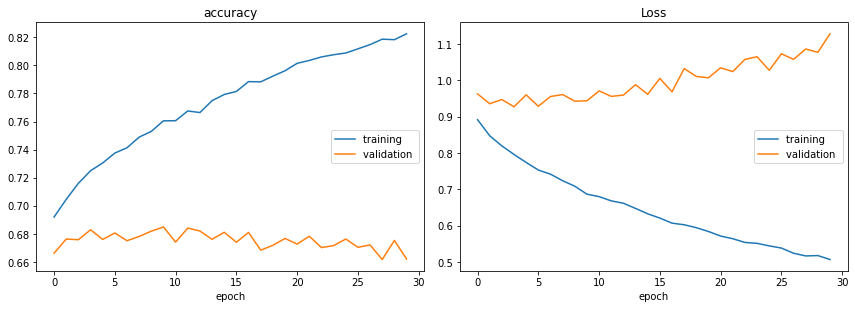

accuracy
	training         	 (min:    0.095, max:    0.823, cur:    0.823)
	validation       	 (min:    0.100, max:    0.685, cur:    0.662)
Loss
	training         	 (min:    0.507, max:    2.303, cur:    0.507)
	validation       	 (min:    0.927, max:    2.303, cur:    1.128)


In [0]:
import torch.optim as optim 

# we use a 
!pip install livelossplot --quiet
from livelossplot import PlotLosses

criterion = nn.CrossEntropyLoss() 

#Here we use Adam over SGD with lr=0.001 based on hyperparameter tuning, with weight_decay=0.001 based on references 
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

dataloaders = {
    "train": trainloader,
    "testing": testloader
}
#make sure it runs on gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def getnumcorrect (preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()


num_epochs=30       # run over 30 epochs
min_loss = 1        # set our minimum loss for stopping 
waiting_loss = 0    # used to calculate stopping
n_epochs_stop = 5   # if there is no improvement on the loss for 5 straight epochs we end the process
epochs_no_improve = 0  # counts how many epochs in a row it goes without loss improvment
early_stop= False     # set to false to start
correctones=[]        # initialize an array for correctones
losses=[]             # initialize an array for losses
liveloss = PlotLosses()
net = net.to(device)
for epoch in range(num_epochs): 
        logs = {}
        for phase in ['train', 'testing']:  
            if phase == 'train':
                net.train()
            else:
                net.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels) 

                if phase == 'train':
                    optimizer.zero_grad() 
                    loss.backward()
                    optimizer.step() 


                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if waiting_loss < running_loss < min_loss:
                  epochs_no_improve += 1

                if epochs_no_improve == n_epochs_stop:
                   print('Early stopping!' )
                   early_stop = True
                   break
                else:
                   continue

                waiting_loss = running_loss
            if early_stop:
              print("Stopped")
              break  

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'testing':
                prefix = 'val_'

            logs[prefix + 'loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 76 %
Accuracy of  bird : 49 %
Accuracy of   cat : 47 %
Accuracy of  deer : 63 %
Accuracy of   dog : 43 %
Accuracy of  frog : 71 %
Accuracy of horse : 61 %
Accuracy of  ship : 77 %
Accuracy of truck : 74 %


NameError: ignored

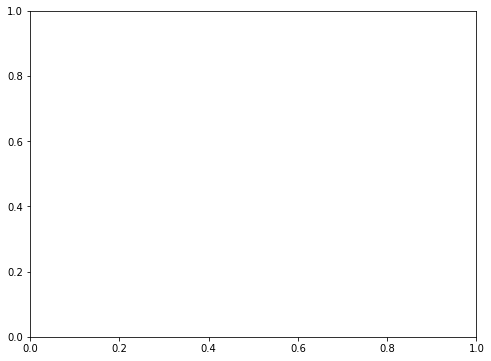

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

**Tensor Board and Hyperparameter Tuning**

In this section we explored Tensor Board and also tune the hyperparameters 'batch size' and 'learning rate'.

In [0]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
%tensorboard --logdir=runs

In [0]:
tb = SummaryWriter()

network = Net()
images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(network, images)
tb.close()

In [0]:
tensorboard --logdir=runs

In [0]:
def getnumcorrect (preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

min_loss = 0.001
n_epochs_stop = 20
epochs_no_improve = 0
early_stop= False 
running_loss = 0.0
total_correct=0.0
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    total_correct=0.0
    for i, data in enumerate(trainloader, 0): #going through all the batches from our training set
        # get the inputs
        inputs, labels = data #we are unpacking the 'images' inputs and labels from the current batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) #pass the 'images' inputs to the network and what we get here is the predicted values (tensor)
        loss = criterion(outputs, labels) #we apply our cross entropy loss function over the predictions and the labels (targets)
        loss.backward() #calculating the gradients by calling the backward function on the loss tensor. When we call backward all of the gradients for all of the tensor are calculated
        optimizer.step() #we call the optimizer (SGD). Here the weights are updated, when we call step in our optimizer we are telling it that we want to step in the direction of the loss function minimum
        #WE CAN CALCULATE NUM OF CORR PREDICTIONS AND GRAPH THEM

        # print statistics
        running_loss += loss.item() 
        total_correct += getnumcorrect(outputs, labels)
        
        if running_loss < min_loss:
          epochs_no_improve += 1
          min_val_loss = running_loss
          
          
              

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('acc',total_correct/len(trainset),'epoch',epoch,'[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            
       
        
        if epochs_no_improve == n_epochs_stop:
          print('Early stopping!' )
          early_stop = True
          break
        else:
          continue
    if early_stop:
      print("Stopped")
      break
    
    tb.add_scalar('Loss', running_loss, epoch)
    tb.add_scalar('Number Correct', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct / len(trainset), epoch)

    tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
    tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
    #tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)

    

print('Finished Training')

In [0]:
batch_size = 100
lr = 0.01


network = Net()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100)

optimizer = optim.Adam(network.parameters(), lr=0.001)


In [0]:
tb = SummaryWriter(comment=f' batch_size={batch_size} lr={lr}')

In [0]:
batch_size_list = [8, 32, 64, 128, 256, 500, 1000]
lr_list = [.01, .001, .0001]
losses = []

def getnumcorrect (preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [0]:

correctones=[]
losses=[]
for batch_size in batch_size_list:
    for lr in lr_list:
        network = Net()

        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=batch_size
        )
        optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

        images, labels = next(iter(trainloader))
        grid = torchvision.utils.make_grid(images)

        comment=f' batch_size={batch_size} lr={lr}'
        tb = SummaryWriter(comment=comment)
        tb.add_image('images', grid)
        tb.add_graph(network, images)
        running_loss=0.0
        total_correct=0.0
        for epoch in range(50):
            
            for i, data in enumerate(trainloader, 0): #going through all the batches from our training set
            
              # get the inputs
              inputs, labels = data #we are unpacking the 'images' inputs and labels from the current batch

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              outputs = network(inputs) #pass the 'images' inputs to the network and what we get here is the predicted values (tensor)
              loss = criterion(outputs, labels) #we apply our cross entropy loss function over the predictions and the labels (targets)
              loss.backward() #calculating the gradients by calling the backward function on the loss tensor. When we call backward all of the gradients for all of the tensor are calculated
              optimizer.step() #we call the optimizer (SGD). Here the weights are updated, when we call step in our optimizer we are telling it that we want to step in the direction of the loss function minimum
              #WE CAN CALCULATE NUM OF CORR PREDICTIONS AND GRAPH THEM

              # print statistics
              running_loss += loss.item() 
              total_correct += getnumcorrect(outputs, labels)
              losses.append(loss.item())
             # if i % 2000 == 1999:    # print every 2000 mini-batches
              #    print('acc',total_correct/len(trainset),'epoch',epoch,'[%d, %5d] loss: %.3f' %
               #         (epoch + 1, i + 1, running_loss / 2000))
                #  running_loss = 0.0
        
            tb.add_scalar(
                'Loss', running_loss, epoch
            )
            tb.add_scalar(
                'Number Correct', total_correct, epoch
            )
            tb.add_scalar(
                'Accuracy', total_correct / len(trainset), epoch 
            )

            for name, param in network.named_parameters():
                tb.add_histogram(name, param, epoch)

            correctones.append(total_correct / len(trainset))
            losses.append(running_loss/ len(trainloader))  
                #tb.add_histogram(f'{name}.grad', param.grad, epoch)

            #if i % 2000 == 1999:    # print every 2000 mini-batches
             # print('acc',total_correct/len(trainset),'epoch',epoch,'[%d, %5d] loss: %.3f' %
                   # (epoch + 1, i + 1, running_loss / 2000))
              #running_loss = 0.0
            
            #print(
             #   "epoch", epoch
              #  ,"total_correct:", total_correct/len(trainset)
               # ,"loss:", running_loss/2000
            #)  
        tb.close()

plt.plot(losses, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Cost (CE)')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(correctones, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [0]:
tensorboard --logdir=runs